<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- K-Fold Cross Validation을 사용해 모델의 성능을 예측합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

In [2]:
# 데이터 읽어오기
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [3]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부 (Target 변수)

In [4]:
# 기술통계 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [5]:
# 제거 대상: id
data.drop(columns=['id'], axis=1, inplace=True)

# 변수 제거


# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY


**2) x, y 분리**

In [6]:
# Target 설정
target = 'CHURN'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

**3) 가변수화**

In [7]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dumm_cols = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(x, columns = dumm_cols, drop_first=True, dtype=int)

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,0,0,1,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0


**4) 학습용, 평가용 데이터 분리**

In [8]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.3)

**5) 정규화**

In [9]:
# 모듈 불러오기
from sklearn.preprocessing import MinMaxScaler

# 정규화
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)


# 4.성능 예측

- K분할 교차 검증 방법으로 모델 성능을 예측합니다.
- cross_val_score(model, x_train, y_train, cv=n) 형태로 사용합니다.
- cv 옵션에 k값(분할 개수, 기본값=5)을 지정합니다.
- cross_val_score 함수는 넘파이 배열 형태의 값을 반환합니다.
- cross_val_score 함수 반환 값의 평균을 해당 모델의 예측 성능으로 볼 수 있습니다.

**1) KNN**

In [22]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 선언하기
model = KNeighborsClassifier()

# 검증하기
cv_score = cross_val_score(model, x_train_s, y_train, cv=10)

# 확인
print(cv_score)
print(cv_score.mean())

result = {}
result['KNN'] = cv_score.mean()


[0.60071429 0.59071429 0.61357143 0.59285714 0.57785714 0.58357143
 0.60214286 0.61357143 0.58857143 0.60928571]
0.5972857142857143


**2) Decision Tree**

In [23]:
# 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 선언하기
model = DecisionTreeClassifier(max_depth=5, random_state=1)

# 검증하기
cv_score = cross_val_score(model, x_train, y_train, cv=10)

# 확인
print(cv_score)
print(cv_score.mean())
result ['Decision Tree'] = cv_score.mean()

[0.69857143 0.69142857 0.70214286 0.69285714 0.69428571 0.69214286
 0.70857143 0.69142857 0.70428571 0.70285714]
0.6978571428571428


**3) Logistic Regression**

In [24]:
# 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# 선언하기
model = LogisticRegression()

# 검증하기
cv_score = cross_val_score(model, x_train, y_train, cv=10)

# 확인
print(cv_score)
print(cv_score.mean())

result['Logistic Regression'] = cv_score.mean()


[0.62642857 0.63       0.63142857 0.64285714 0.62571429 0.62571429
 0.64928571 0.63642857 0.65285714 0.62142857]
0.6342142857142857


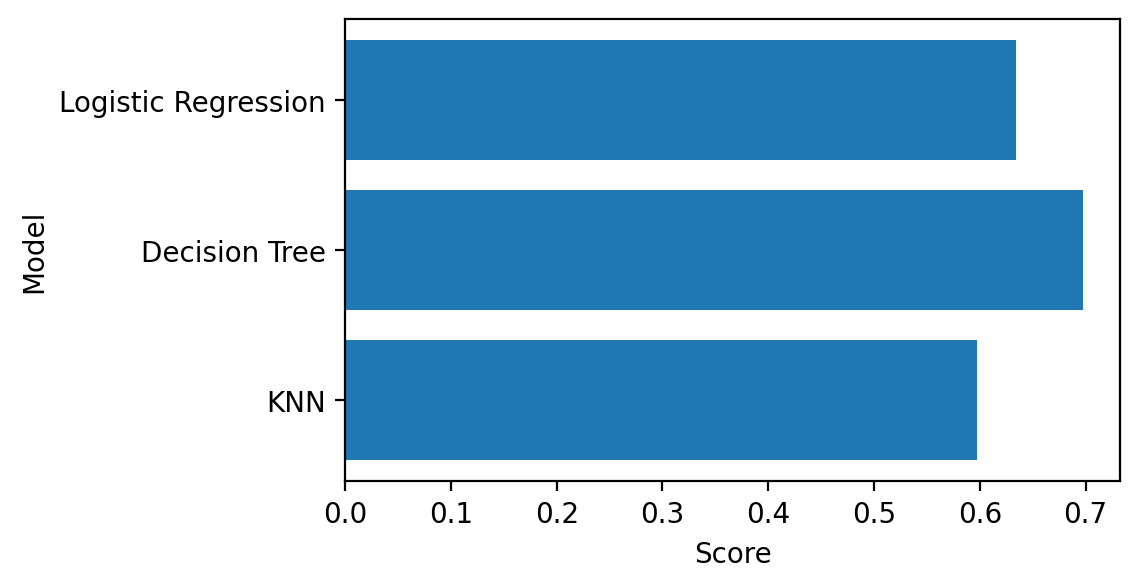

In [25]:
# 성능 시각화 비교
plt.figure(figsize=(5, 3))
plt.barh(y=list(result), width=result.values())
plt.xlabel('Score')
plt.ylabel('Model')
plt.show()

In [21]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       LEAVE       0.62      0.61      0.62      2935
        STAY       0.63      0.64      0.64      3065

    accuracy                           0.63      6000
   macro avg       0.63      0.63      0.63      6000
weighted avg       0.63      0.63      0.63      6000

